# Model training

In [8]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.metrics

import torch
import torchvision.transforms as transforms
import torchvision.models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
import time

import data_reader
import dataset
from plots import learning_curve_train

In [9]:
# Choosing device for tensor processing

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU :", device)
else:
    device = torch.device("cpu")
    print("Using CPU ")

Using GPU : cuda:0


In [11]:
# Training and data variables

MODE = "w"
EXP_NAME = "256_tcia_25ep"#"tcia_effnet"

DATA_SET_NAME =  f"train_256_tcia_data_set_SPLIT" # "data_set_X20_100%_SPLIT" # f"tcia_data_set_SPLIT" # 
PATCH_SIZE = 256

BATCH_SIZE = 16
EPOCHS = 25

SIZE_X = PATCH_SIZE
SIZE_Y = PATCH_SIZE

fine_tuning = True

In [12]:
def init_weights(m): # XAVIER initialization for final layer weight initialization
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

def init(fine_tuning=False):
    global net, loss_function, scheduler, optimizer, MODEL_NAME

    if fine_tuning == True:
        print(f"Loading {MODEL_NAME}")
        net = torch.load(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth") # Model loading

        for param in net.layer4[1].parameters():
           param.requires_grad = True

        '''
        for param in net.features[8].parameters():
            param.requires_grad = True

        for param in net.features[9].parameters():# net.layer4[1].parameters():
            param.requires_grad = True # Unfreezing the last residual block
        '''

        n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.features[8].parameters())

        learning_rate = 1E-8 # LR

        optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)# Optimizer

    else:
        net = torchvision.models.resnet18(pretrained=True).to(device)
        #net = torchvision.models.efficientnet_b1(pretrained=True).to(device) 
    
        net.fc = nn.Sequential(
                    nn.Dropout(p=0.5),  
                    nn.Linear(512, 2),
                    #nn.ReLU(inplace=True),
                    #nn.Linear(512, 2),
                    nn.Softmax(dim = -1)
                    ).to(device)

        for param in net.fc.parameters():
            param.requires_grad = True

        net.fc.apply(init_weights) # Xavier init

        n_params = sum(p.numel() for p in net.fc.parameters())# + sum(p.numel() for p in net.layer4[1].parameters())
    
        learning_rate = 1E-4#1E-3

        optimizer = optim.Adam(net.fc.parameters(), lr=learning_rate)#, betas=(0.9, 0.999), eps=1e-08)# Optimizer

    print("Number of free parameters: ", n_params)
    #Hyperparameters:
    loss_function = nn.CrossEntropyLoss()  # Loss
    lambda1 = lambda epoch: 0.8 ** epoch # Scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


In [13]:
def fwd_pass(X, y, train=False):
    if train: 
        net.zero_grad()
        
    # NORMALIZATION
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = torchvision.transforms.Normalize(mean=mean, std=std)

    for i, x in enumerate(X):
        X[i] = normalize(X[i]/255) # Np array

    outputs = net(X)
    
    y_pred = [torch.argmax(i) for i in outputs.cpu()]
    y_true = [torch.argmax(i) for i in y.cpu()]

    loss = loss_function(outputs, y)
    conf_m = sklearn.metrics.confusion_matrix(y_true, y_pred, labels=[0, 1])
    acc = sklearn.metrics.accuracy_score(y_true, y_pred)
    f1 = sklearn.metrics.f1_score(y_true, y_pred)
    auc = 0 #sklearn.metrics.roc_auc_score(y_true, y_pred, average= "micro", multi_class="ovr") #!!!!

    if train:
        loss.backward() # Calculate gradients using backprop
        optimizer.step() # Updates W and b using previously calculated gradients

    return [acc, loss, conf_m, f1, auc]

In [14]:
def train():
  global net, loss_function, scheduler, optimizer, train_set, val_set, MODEL_NAME, EPOCHS
  
  print(MODEL_NAME)
  patience, prev_val_loss = 0, 0

  with open(f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\log\\model_{MODEL_NAME}.log", MODE) as f:
    for epoch in range(EPOCHS):
      acc, loss, f1, auc = 0, 0, 0, 0
      val_acc, val_loss, val_f1, val_auc = 0, 0, 0, 0
      conf_m, val_conf_m = np.zeros((2,2)), np.zeros((2,2))

      print("\nEPOCH: ", epoch+1)

      n_patches = sum(len(batch[0]) for batch in iter(train_dataloader))

      for batch_X, batch_y in tqdm(iter(train_dataloader)):
         # Number of patches in dataloader
        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0,3,2,1), batch_y.type(torch.FloatTensor).to(device) 
        
        net.train() # Making sure that the model is in training mode
        
        performance_metrics = fwd_pass(batch_X, batch_y, train=True)
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]
        acc += acc_aux*(len(batch_X)/n_patches) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        loss += loss_aux*(len(batch_X)/n_patches)
        conf_m += conf_m_aux
        f1 += f1_aux*(len(batch_X)/n_patches)
        auc += auc_aux*(len(batch_X)/n_patches)

      for batch_X, batch_y in tqdm(iter(val_dataloader)):

        batch_X, batch_y = batch_X.type(torch.FloatTensor).to(device).permute(0, 3, 2, 1), batch_y.type(torch.FloatTensor).to(device)

        net.eval() # Making sure that the model is not training and deactivate droptout
        
        with torch.no_grad(): # Disable all computations, works together with net.eval()
          performance_metrics = fwd_pass(batch_X, batch_y, train=False)
          
        acc_aux, loss_aux, conf_m_aux, f1_aux, auc_aux = performance_metrics[0], performance_metrics[1], performance_metrics[2], performance_metrics[3], performance_metrics[4]  
        val_acc += acc_aux*(len(batch_X)/len(val_set)) # Calculating the average loss and acc through batches sum ACCi*Wi/N (Wi = weight of the batch)
        val_loss += loss_aux*(len(batch_X)/len(val_set))
        val_conf_m += conf_m_aux
        val_f1 += f1_aux*(len(batch_X)/len(val_set))
        val_auc += auc_aux*(len(batch_X)/len(val_set))
        
      print("Val loss: ", val_loss.item(), " Train loss: ", loss.item(), "\n")
      print("Val acc: ", val_acc, " Train acc: ", acc, "\n")
      print("Val AUC: ", val_auc, " Train AUC: ", auc)
      print("Val f1: ", val_f1, " Train f1: ", f1, "\n")
      print("Val CONF: \n", val_conf_m, "\nTrain CONF: \n", conf_m, "\n")

      conf_m = f"{conf_m[0][0]}+{conf_m[0][1]}+{conf_m[1][0]}+{conf_m[1][1]}"
      val_conf_m = f"{val_conf_m[0][0]}+{val_conf_m[0][1]}+{val_conf_m[1][0]}+{val_conf_m[1][1]}"
    
      f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),3)},{round(float(loss),4)},{conf_m},{round(float(auc),4)},")
      f.write(f"{round(float(val_acc),3)},{round(float(val_loss),4)},{val_conf_m}, {round(float(val_auc),4)}\n")
      f.write("\n\n")

      # Early stopping, if the difference between loss and validation loss 
      # is bigger than the threshold for 3 epochs in a row training is stopped
      if val_loss.item()>prev_val_loss:
        patience +=1
      else:
        patience = 0

      print("Learning Rate: ", optimizer.param_groups[0]["lr"])
      scheduler.step() # Changing the learning rate

      if patience >= 2:
        print("Stopping early: ")
        break
      prev_val_loss = val_loss.item()

    torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

In [15]:
# Choosing only the images from the according splits (10CV)

SPLITS = [1,2,3,4,5,6,7,8,9] # Number of iterations > n_splits
n_splits = 10 # Number of splits to use

for SPLIT in SPLITS:
    MODEL_NAME = EXP_NAME + f"{SPLIT}"

    TRAIN_SPLITS = list(range(n_splits))
    # We take out the SPLIT and SPLIT+1 sets for val and testing
    if SPLIT == n_splits-1: # For the final split for validation we take the first one for test
        TRAIN_SPLITS.remove(0) 
    else:
        TRAIN_SPLITS.remove(SPLIT+1)
    TRAIN_SPLITS.remove(SPLIT)

    train_set = dataset.PatchDataset([], [], [])
    val_set = dataset.PatchDataset([], [], [])
    test_set = dataset.PatchDataset([], [], [])

    # Loading training splits:
    for i in TRAIN_SPLITS:
        print(f"Loading training split: {i}")
        SPLIT_NAME = DATA_SET_NAME + f"{i}"
        
        X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

        train_set.inputs.extend(X_)
        train_set.labels.extend(y_)
        train_set.case_ids.extend(patch_ids_)

    # Random oversampler
    negative =  [i[0] for i in train_set.labels]
    positive =  [i[1] for i in train_set.labels]

    class_sample_count = np.array([sum(negative), sum(positive)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[np.argmax(t)] for t in train_set.labels])
    samples_weight = torch.from_numpy(samples_weight) # Probability for a sample to be sampled
    #samples_weight = torch.tensor([1/len(samples_weight)]*len(samples_weight))
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), 2*int(sum(negative)))#, replacement=False) #int(len(train_set)))#
    # Will take len(samples_weight) number of samples, this can be changed

    # Creating DataLoader
    train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
    
    print(f"Patches for training: {len(train_set)}\n")
    
    # Loading validation splits:
    SPLIT_NAME = DATA_SET_NAME + f"{SPLIT}"

    print(f"Loading validation split: {SPLIT}")

    X_, y_, _ , patch_ids_ = data_reader.read_lmdb(f"D:/data/WSI/patches/{SPLIT_NAME}")

    val_set.inputs.extend(X_)
    val_set.labels.extend(y_)
    val_set.case_ids.extend(patch_ids_)

    val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)

    print(f"Patches for validation: {len(val_set)}\n")

    init(fine_tuning=fine_tuning)

    train()

    del train_set, val_set, test_set


Loading training split: 0
Read lmdb
26772
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
28378
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 208992

Loading validation split: 1
Read lmdb
29594
Patches for validation: 29594

Loading 256_tcia_25ep1
Number of free parameters:  1026
256_tcia_25ep1

EPOCH:  1


  0%|          | 0/8256 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.5850934386253357  Train loss:  0.5662650465965271 

Val acc:  0.7101101574643487  Train acc:  0.7304221428138687 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.7608681391239848  Train f1:  0.7291760074401779 

Val CONF: 
 [[ 6678.  3843.]
 [ 4736. 14337.]] 
Train CONF: 
 [[46520. 19243.]
 [16365. 49960.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8256 [00:00<?, ?it/s]

  0%|          | 0/1850 [00:00<?, ?it/s]

Val loss:  0.5864289402961731  Train loss:  0.5641944408416748 

Val acc:  0.7075758599716148  Train acc:  0.7325949367088507 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.7600996575348925  Train f1:  0.7307480043547425 

Val CONF: 
 [[ 6482.  4039.]
 [ 4615. 14458.]] 
Train CONF: 
 [[46987. 19191.]
 [16130. 49780.]] 

Learning Rate:  8e-09
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 4
Read lmdb
28378
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 210705

Loading validation split: 2
Read lmdb
27300
Patches for validation: 27300

Loading 256_tcia_25ep2
Number of free parameters:  1026
256_tcia_25ep2

EPOCH:  1


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5470466613769531  Train loss:  0.5684623718261719 

Val acc:  0.7534798534798511  Train acc:  0.7263990124617867 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8052177182662871  Train f1:  0.7169063299155033 

Val CONF: 
 [[ 5976.  2017.]
 [ 4713. 14594.]] 
Train CONF: 
 [[49909. 18525.]
 [18711. 48951.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5422292947769165  Train loss:  0.5708288550376892 

Val acc:  0.7590476190476174  Train acc:  0.7234378673877193 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8114868741708577  Train f1:  0.7150301615076018 

Val CONF: 
 [[ 5908.  2085.]
 [ 4493. 14814.]] 
Train CONF: 
 [[49550. 18571.]
 [19068. 48907.]] 

Learning Rate:  8e-09

EPOCH:  3


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5332396030426025  Train loss:  0.5676186680793762 

Val acc:  0.7699633699633673  Train acc:  0.7279126498941896 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8227748685348362  Train f1:  0.7206514688799659 

Val CONF: 
 [[ 5755.  2238.]
 [ 4042. 15265.]] 
Train CONF: 
 [[49549. 18095.]
 [18935. 49517.]] 

Learning Rate:  6.400000000000001e-09

EPOCH:  4


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5330291986465454  Train loss:  0.5659849643707275 

Val acc:  0.7696703296703273  Train acc:  0.729426287326589 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8219088499835674  Train f1:  0.7213688340540777 

Val CONF: 
 [[ 5817.  2176.]
 [ 4112. 15195.]] 
Train CONF: 
 [[49765. 18164.]
 [18660. 49507.]] 

Learning Rate:  5.120000000000001e-09

EPOCH:  5


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5380480289459229  Train loss:  0.5678165555000305 

Val acc:  0.7636996336996326  Train acc:  0.7274130025864051 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8149640777567742  Train f1:  0.7198043406877869 

Val CONF: 
 [[ 5827.  2166.]
 [ 4285. 15022.]] 
Train CONF: 
 [[49620. 18479.]
 [18619. 49378.]] 

Learning Rate:  4.096000000000001e-09

EPOCH:  6


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5360535383224487  Train loss:  0.5675268769264221 

Val acc:  0.7672893772893765  Train acc:  0.7282506466023921 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8194640679740994  Train f1:  0.7209261451040677 

Val CONF: 
 [[ 5829.  2164.]
 [ 4189. 15118.]] 
Train CONF: 
 [[49539. 18228.]
 [18756. 49573.]] 

Learning Rate:  3.276800000000001e-09

EPOCH:  7


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5398536324501038  Train loss:  0.5655169486999512 

Val acc:  0.7623443223443218  Train acc:  0.7304549729602641 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8140801192282567  Train f1:  0.7227301209181918 

Val CONF: 
 [[ 5887.  2106.]
 [ 4382. 14925.]] 
Train CONF: 
 [[49855. 18288.]
 [18396. 49557.]] 

Learning Rate:  2.6214400000000012e-09

EPOCH:  8


  0%|          | 0/8506 [00:00<?, ?it/s]

  0%|          | 0/1707 [00:00<?, ?it/s]

Val loss:  0.5412338972091675  Train loss:  0.5665603876113892 

Val acc:  0.7605494505494491  Train acc:  0.7292572889724891 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8127859024554381  Train f1:  0.7208722336458461 

Val CONF: 
 [[ 5868.  2125.]
 [ 4412. 14895.]] 
Train CONF: 
 [[49829. 18491.]
 [18356. 49420.]] 

Learning Rate:  2.0971520000000006e-09
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 209627

Loading validation split: 3
Read lmdb
27881
Patches for validation: 27881

Loading 256_tcia_25ep3
Number of free parameters:  1026
256_tcia_25ep3

EPOCH:  1


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5442028641700745  Train loss:  0.5756955742835999 

Val acc:  0.7577561780423963  Train acc:  0.7196642539991449 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8072277301333632  Train f1:  0.717312133866269 

Val CONF: 
 [[ 6256.  2261.]
 [ 4493. 14871.]] 
Train CONF: 
 [[46039. 19672.]
 [17200. 48617.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5342812538146973  Train loss:  0.5773216485977173 

Val acc:  0.7710268641727369  Train acc:  0.7166534882306398 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8234333372006639  Train f1:  0.7146366865007384 

Val CONF: 
 [[ 5918.  2599.]
 [ 3785. 15579.]] 
Train CONF: 
 [[45800. 19976.]
 [17292. 48460.]] 

Learning Rate:  8e-09

EPOCH:  3


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5369669795036316  Train loss:  0.5747257471084595 

Val acc:  0.7670456583336354  Train acc:  0.7198163128763417 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8176831944214087  Train f1:  0.7181406654294104 

Val CONF: 
 [[ 6096.  2421.]
 [ 4074. 15290.]] 
Train CONF: 
 [[45903. 19716.]
 [17136. 48773.]] 

Learning Rate:  6.400000000000001e-09

EPOCH:  4


  0%|          | 0/8221 [00:00<?, ?it/s]

  0%|          | 0/1743 [00:00<?, ?it/s]

Val loss:  0.5535696744918823  Train loss:  0.5739942789077759 

Val acc:  0.7441985581578876  Train acc:  0.7197326804938857 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.7922849827364253  Train f1:  0.7178545276939035 

Val CONF: 
 [[ 6402.  2115.]
 [ 5017. 14347.]] 
Train CONF: 
 [[45985. 19676.]
 [17187. 48680.]] 

Learning Rate:  5.120000000000001e-09
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 207336

Loading validation split: 4
Read lmdb
28378
Patches for validation: 28378

Loading 256_tcia_25ep4
Number of free parameters:  1026
256_tcia_25ep4

EPOCH:  1


  0%|          | 0/8158 [00:00<?, ?it/s]

  0%|          | 0/1774 [00:00<?, ?it/s]

Val loss:  0.49226659536361694  Train loss:  0.5755767822265625 

Val acc:  0.8171470857706726  Train acc:  0.7186384321897481 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8419231224271756  Train f1:  0.7144141433646612 

Val CONF: 
 [[ 8604.  1673.]
 [ 3516. 14585.]] 
Train CONF: 
 [[46058. 19209.]
 [17516. 47743.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8158 [00:00<?, ?it/s]

  0%|          | 0/1774 [00:00<?, ?it/s]

Val loss:  0.4848673343658447  Train loss:  0.5741921067237854 

Val acc:  0.8239481288321985  Train acc:  0.720362226682803 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8498151930729017  Train f1:  0.7168151062426041 

Val CONF: 
 [[ 8495.  1782.]
 [ 3214. 14887.]] 
Train CONF: 
 [[45981. 19340.]
 [17160. 48045.]] 

Learning Rate:  8e-09

EPOCH:  3


  0%|          | 0/8158 [00:00<?, ?it/s]

  0%|          | 0/1774 [00:00<?, ?it/s]

Val loss:  0.480876624584198  Train loss:  0.5758380889892578 

Val acc:  0.8278596095567047  Train acc:  0.7190291589415105 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8549013170404903  Train f1:  0.7150048268572528 

Val CONF: 
 [[ 8367.  1910.]
 [ 2975. 15126.]] 
Train CONF: 
 [[46034. 19331.]
 [17343. 47818.]] 

Learning Rate:  6.400000000000001e-09

EPOCH:  4


  0%|          | 0/8158 [00:00<?, ?it/s]

  0%|          | 0/1774 [00:00<?, ?it/s]

Val loss:  0.483739972114563  Train loss:  0.5727587342262268 

Val acc:  0.824829092959341  Train acc:  0.7213045676723339 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8502086232421269  Train f1:  0.718111675908881 

Val CONF: 
 [[ 8521.  1756.]
 [ 3215. 14886.]] 
Train CONF: 
 [[46118. 18916.]
 [17461. 48031.]] 

Learning Rate:  5.120000000000001e-09

EPOCH:  5


  0%|          | 0/8158 [00:00<?, ?it/s]

  0%|          | 0/1774 [00:00<?, ?it/s]

Val loss:  0.4899263083934784  Train loss:  0.5727963447570801 

Val acc:  0.816865177249987  Train acc:  0.7218408592923978 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8423146481927374  Train f1:  0.7189837309759328 

Val CONF: 
 [[ 8554.  1723.]
 [ 3474. 14627.]] 
Train CONF: 
 [[46001. 18946.]
 [17361. 48218.]] 

Learning Rate:  4.096000000000001e-09
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
28378
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 209487

Loading validation split: 5
Read lmdb
30172
Patches for validation: 30172

Loading 256_tcia_25ep5
Number of free parameters:  1026
256_tcia_25ep5

EPOCH:  1


  0%|          | 0/8388 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5497050285339355  Train loss:  0.5746615529060364 

Val acc:  0.7483096911043514  Train acc:  0.7189097357793398 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8047154853797197  Train f1:  0.7170772522612783 

Val CONF: 
 [[ 6175.  2843.]
 [ 4751. 16403.]] 
Train CONF: 
 [[46820. 20085.]
 [17639. 49662.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8388 [00:00<?, ?it/s]

  0%|          | 0/1886 [00:00<?, ?it/s]

Val loss:  0.5647879838943481  Train loss:  0.5745924115180969 

Val acc:  0.7287882805250063  Train acc:  0.7205564579825213 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.7841175592032072  Train f1:  0.7179928110799018 

Val CONF: 
 [[ 6368.  2650.]
 [ 5533. 15621.]] 
Train CONF: 
 [[47033. 20143.]
 [17360. 49670.]] 

Learning Rate:  8e-09
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
28378
Loading training split: 5
Read lmdb
30172
Loading training split: 8
Read lmdb
26957
Loading training split: 9
Read lmdb
23642
Patches for training: 220696

Loading validation split: 6
Read lmdb
26227
Patches for validation: 26227

Loading 256_tcia_25ep6
Number of free parameters:  1026
256_tcia_25ep6

EPOCH:  1


  0%|          | 0/8827 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5416738986968994  Train loss:  0.5656898021697998 

Val acc:  0.760170816334308  Train acc:  0.7301450178440012 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8045102836847908  Train f1:  0.7279652153343008 

Val CONF: 
 [[ 6327.  2110.]
 [ 4180. 13610.]] 
Train CONF: 
 [[50076. 20890.]
 [17220. 53038.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8827 [00:00<?, ?it/s]

  0%|          | 0/1640 [00:00<?, ?it/s]

Val loss:  0.5438900589942932  Train loss:  0.567887008190155 

Val acc:  0.7561291798528198  Train acc:  0.7277728997904114 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.7986285151519352  Train f1:  0.7262919576979036 

Val CONF: 
 [[ 6475.  1962.]
 [ 4434. 13356.]] 
Train CONF: 
 [[49764. 20919.]
 [17526. 53015.]] 

Learning Rate:  8e-09
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
28378
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 9
Read lmdb
23642
Patches for training: 219966

Loading validation split: 7
Read lmdb
18963
Patches for validation: 18963

Loading 256_tcia_25ep7
Number of free parameters:  1026
256_tcia_25ep7

EPOCH:  1


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5456424355506897  Train loss:  0.5696054697036743 

Val acc:  0.7540473553762569  Train acc:  0.7260606932259447 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8146955067401374  Train f1:  0.730361880344232 

Val CONF: 
 [[ 3567.  1942.]
 [ 2722. 10732.]] 
Train CONF: 
 [[47215. 22419.]
 [15675. 53751.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5347194671630859  Train loss:  0.5689941048622131 

Val acc:  0.7629067130728224  Train acc:  0.7274198187832587 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8267249646670426  Train f1:  0.7314954113438082 

Val CONF: 
 [[ 3275.  2234.]
 [ 2262. 11192.]] 
Train CONF: 
 [[47356. 22373.]
 [15532. 53799.]] 

Learning Rate:  8e-09

EPOCH:  3


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5534880757331848  Train loss:  0.5693656802177429 

Val acc:  0.7465590887517766  Train acc:  0.7257658564648354 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.804115130500131  Train f1:  0.7305068168116089 

Val CONF: 
 [[ 3774.  1735.]
 [ 3071. 10383.]] 
Train CONF: 
 [[47159. 22313.]
 [15822. 53766.]] 

Learning Rate:  6.400000000000001e-09

EPOCH:  4


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5428482890129089  Train loss:  0.5705348253250122 

Val acc:  0.7562094605283949  Train acc:  0.7251114626779798 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8189998873778244  Train f1:  0.7288953496567216 

Val CONF: 
 [[ 3389.  2120.]
 [ 2503. 10951.]] 
Train CONF: 
 [[47331. 22452.]
 [15774. 53503.]] 

Learning Rate:  5.120000000000001e-09

EPOCH:  5


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5388191938400269  Train loss:  0.5684569478034973 

Val acc:  0.7606918736486815  Train acc:  0.7269595857903058 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8246202733078306  Train f1:  0.7305640854058578 

Val CONF: 
 [[ 3321.  2188.]
 [ 2350. 11104.]] 
Train CONF: 
 [[47476. 22318.]
 [15651. 53615.]] 

Learning Rate:  4.096000000000001e-09

EPOCH:  6


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5555252432823181  Train loss:  0.5681553483009338 

Val acc:  0.7433950324315738  Train acc:  0.7272975693945043 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8013494105014344  Train f1:  0.7311281748041077 

Val CONF: 
 [[ 3814.  1695.]
 [ 3171. 10283.]] 
Train CONF: 
 [[47462. 22084.]
 [15838. 53676.]] 

Learning Rate:  3.276800000000001e-09

EPOCH:  7


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5405646562576294  Train loss:  0.5675081610679626 

Val acc:  0.7586879713125536  Train acc:  0.7281748885373228 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.820249867949717  Train f1:  0.7318325293412569 

Val CONF: 
 [[ 3458.  2051.]
 [ 2525. 10929.]] 
Train CONF: 
 [[47476. 22224.]
 [15576. 53784.]] 

Learning Rate:  2.6214400000000012e-09

EPOCH:  8


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.5453601479530334  Train loss:  0.5691317319869995 

Val acc:  0.7530454042081913  Train acc:  0.7263771034085965 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8124535619604254  Train f1:  0.7303405390798291 

Val CONF: 
 [[ 3654.  1855.]
 [ 2828. 10626.]] 
Train CONF: 
 [[47363. 22235.]
 [15815. 53647.]] 

Learning Rate:  2.0971520000000006e-09

EPOCH:  9


  0%|          | 0/8692 [00:00<?, ?it/s]

  0%|          | 0/1186 [00:00<?, ?it/s]

Val loss:  0.550852358341217  Train loss:  0.5669438242912292 

Val acc:  0.7491430680799422  Train acc:  0.7289371494319021 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8079410884721998  Train f1:  0.7333296894465586 

Val CONF: 
 [[ 3721.  1788.]
 [ 2969. 10485.]] 
Train CONF: 
 [[47519. 22029.]
 [15665. 53847.]] 

Learning Rate:  1.677721600000001e-09
Stopping early: 
Loading training split: 0
Read lmdb
26772
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
28378
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Patches for training: 215287

Loading validation split: 8
Read lmdb
26957
Patches for validation: 26957

Loading 256_tcia_25ep8
Number of free parameters:  1026
256_tcia_25ep8

EPOCH:  1


  0%|          | 0/8599 [00:00<?, ?it/s]

  0%|          | 0/1685 [00:00<?, ?it/s]

Val loss:  0.504089891910553  Train loss:  0.5690858364105225 

Val acc:  0.8013132025076963  Train acc:  0.7259518236926944 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8408771888106549  Train f1:  0.728884807070159 

Val CONF: 
 [[ 6676.  2843.]
 [ 2513. 14925.]] 
Train CONF: 
 [[47128. 21472.]
 [16231. 52747.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8599 [00:00<?, ?it/s]

  0%|          | 0/1685 [00:00<?, ?it/s]

Val loss:  0.5058364272117615  Train loss:  0.5679426193237305 

Val acc:  0.799087435545497  Train acc:  0.7267659073397891 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8412965948149458  Train f1:  0.7289024543655122 

Val CONF: 
 [[ 6474.  3045.]
 [ 2371. 15067.]] 
Train CONF: 
 [[47384. 21711.]
 [15880. 52603.]] 

Learning Rate:  8e-09
Stopping early: 
Loading training split: 1
Read lmdb
29594
Loading training split: 2
Read lmdb
27300
Loading training split: 3
Read lmdb
27881
Loading training split: 4
Read lmdb
28378
Loading training split: 5
Read lmdb
30172
Loading training split: 6
Read lmdb
26227
Loading training split: 7
Read lmdb
18963
Loading training split: 8
Read lmdb
26957
Patches for training: 215472

Loading validation split: 9
Read lmdb
23642
Patches for validation: 23642

Loading 256_tcia_25ep9
Number of free parameters:  1026
256_tcia_25ep9

EPOCH:  1


  0%|          | 0/8724 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5401682257652283  Train loss:  0.5644124746322632 

Val acc:  0.7632180018611016  Train acc:  0.731548480463074 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8305352270338315  Train f1:  0.7319724171160522 

Val CONF: 
 [[ 3647.  2603.]
 [ 2995. 14397.]] 
Train CONF: 
 [[48914. 20972.]
 [16499. 53197.]] 

Learning Rate:  1e-08

EPOCH:  2


  0%|          | 0/8724 [00:00<?, ?it/s]

  0%|          | 0/1478 [00:00<?, ?it/s]

Val loss:  0.5541433691978455  Train loss:  0.5639380216598511 

Val acc:  0.7469757211741868  Train acc:  0.7320571420383453 

Val AUC:  0.0  Train AUC:  0.0
Val f1:  0.8134542291108401  Train f1:  0.7319712251381135 

Val CONF: 
 [[ 3972.  2278.]
 [ 3704. 13688.]] 
Train CONF: 
 [[49102. 20988.]
 [16412. 53080.]] 

Learning Rate:  8e-09
Stopping early: 


In [14]:
torch.save(net, f"C:\\Users\\Alejandro\\Desktop\\heterogeneous-data\\results\\WSI\\models\\{MODEL_NAME}.pth")

tcia_25ep0


c:\Users\Alejandro\Desktop\heterogeneous-data\src\WSI\plots.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


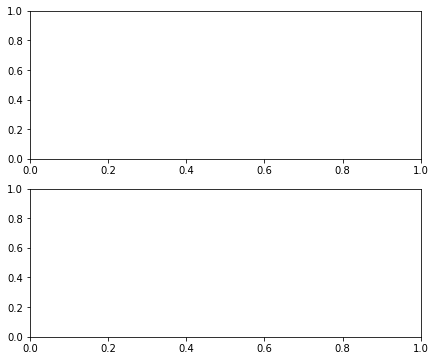

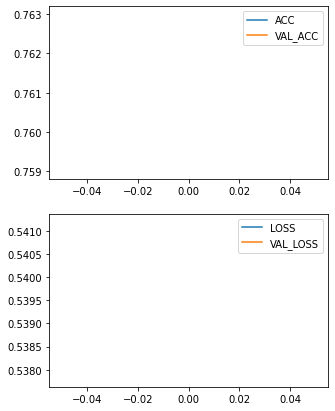

In [9]:
for SPLIT in range(1):
    NAME = EXP_NAME + f"{SPLIT}"
    print(NAME)
    learning_curve_train(NAME)